In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


In [2]:
warnings.filterwarnings("ignore")
nlp = spacy.load('en_core_web_sm')

In [3]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
df_newsgroups = pd.DataFrame({
    'Category': newsgroups.target,
    'Text': newsgroups.data    
})

df_newsgroups.head()

,Category,Text
0,10,\n\nI am sure some bashers of Pens fans are pr...
1,3,My brother is in the market for a high-perform...
2,17,\n\n\n\n\tFinally you said what you dream abou...
3,3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,4,1) I have an old Jasmine drive which I cann...


In [4]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

In [7]:
df_newsgroups['cleaned_text'] = df_newsgroups['Text'].apply(clean_text)


In [11]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df_newsgroups['lemmatized_text'] = df_newsgroups['cleaned_text'].apply(lemmatize_text)

print(df_newsgroups[['cleaned_text', 'lemmatized_text']].head())

                                        cleaned_text  \
0  sure bashers pens fans pretty confused lack ki...   
1  brother market highperformance video card supp...   
2  finally said dream mediterranean new area grea...   
3  think scsi card doing dma transfers disks scsi...   
4  old jasmine drive use new understanding upsate...   

                                     lemmatized_text  
0  sure basher pen fan pretty confused lack kind ...  
1  brother market highperformance video card supp...  
2  finally say dream mediterranean new area great...  
3  think scsi card dma transfer disk scsi card dm...  
4  old jasmine drive use new understanding upsate...  


## Using Tf-idf on unigrams

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df_newsgroups['cleaned_text'])

num_features = X_tfidf.shape[1]
print(f"Number of features: {num_features}")


Number of features: 116765


          Term   Frequency
47122     just  243.018907
51145     like  242.934684
48622     know  240.946988
25145     dont  239.985079
79051   people  207.763828
102876   think  203.595734
24960     does  201.390874
42419       im  200.816751
108003     use  176.421135
102494  thanks  173.696994


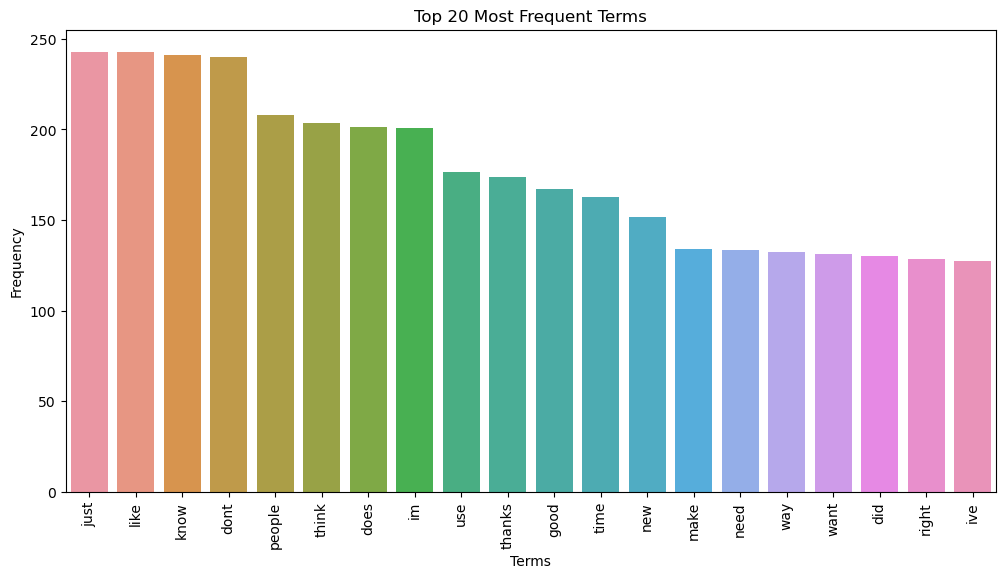

In [13]:
term_frequencies = X_tfidf.sum(axis=0).A1  
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame(list(zip(terms, term_frequencies)), columns=['Term', 'Frequency'])

term_freq_df_sorted = term_freq_df.sort_values(by='Frequency', ascending=False)

print(term_freq_df_sorted.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=term_freq_df_sorted['Term'][:20], y=term_freq_df_sorted['Frequency'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Terms')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.show()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_newsgroups['Category'], test_size=0.2, random_state=42)

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 0.1, 0.01, 0.001]  
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)  

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7289070630400194
Test Accuracy: 0.7254641909814323


In [28]:
nb = MultinomialNB(fit_prior=True, alpha = 1)
nb.fit(X_train, y_train)
y_pred_nb2 = nb.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_nb2)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_nb2, target_names=newsgroups.target_names))

Accuracy: 0.7045092838196286
Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.74      0.26      0.38       151
           comp.graphics       0.68      0.69      0.69       202
 comp.os.ms-windows.misc       0.68      0.63      0.65       195
comp.sys.ibm.pc.hardware       0.52      0.77      0.62       183
   comp.sys.mac.hardware       0.85      0.64      0.73       205
          comp.windows.x       0.86      0.80      0.83       215
            misc.forsale       0.81      0.66      0.73       193
               rec.autos       0.80      0.73      0.77       196
         rec.motorcycles       0.48      0.75      0.58       168
      rec.sport.baseball       0.89      0.82      0.86       211
        rec.sport.hockey       0.89      0.91      0.90       198
               sci.crypt       0.69      0.84      0.76       201
         sci.electronics       0.83      0.62      0.71       202
                 sci.me

In [50]:
nb = MultinomialNB(fit_prior=True, alpha = 0.01)
nb.fit(X_train, y_train)
y_pred_nb2 = nb.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_nb2)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_nb2, target_names=newsgroups.target_names))

Accuracy: 0.7551724137931034
Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.66      0.59      0.62       151
           comp.graphics       0.71      0.75      0.73       202
 comp.os.ms-windows.misc       0.75      0.65      0.70       195
comp.sys.ibm.pc.hardware       0.60      0.74      0.66       183
   comp.sys.mac.hardware       0.78      0.72      0.75       205
          comp.windows.x       0.88      0.81      0.85       215
            misc.forsale       0.82      0.65      0.72       193
               rec.autos       0.82      0.77      0.79       196
         rec.motorcycles       0.49      0.80      0.61       168
      rec.sport.baseball       0.91      0.86      0.88       211
        rec.sport.hockey       0.93      0.91      0.92       198
               sci.crypt       0.83      0.80      0.81       201
         sci.electronics       0.78      0.72      0.75       202
                 sci.me

In [60]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
0.6734545999278049
